In [2]:
import numpy as np
from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt
from halotools.sim_manager import CachedHaloCatalog
from halotools.mock_observables import wp
from halotools.empirical_models import PrebuiltHodModelFactory,  Zheng07Cens, Zheng07Sats, TrivialPhaseSpace,NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array
from astropy.cosmology import FlatLambdaCDM
from tabcorr import TabCorr
import emcee
import warnings
warnings.filterwarnings("ignore")
import scipy.constants as sc
import scipy.stats as ss

In [3]:
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115) # smdpl
param = 'vmax'
threshold=19
dname = '21'
Lbox = 400

In [4]:
#halocat = CachedHaloCatalog(simname='bolplanck')
#halocat3 = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_1.00231.list.halotools_v0p4.hdf5',update_cached_fname = True)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/Downloads/hlist_1.00231.list.halotools_v0p1.hdf5',update_cached_fname = True)
halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/smdpl.dat.smdpl2.hdf5',update_cached_fname = True)
#halocat = CachedHaloCatalog(fname='/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/2019-07-03-18-38-02-9731.dat.my_cosmosim_halos.hdf5')
#model_instance = PrebuiltHodModelFactory('zheng07')

In [5]:
halocat.halo_table

halo_id,halo_rockstarId,halo_pid,halo_upid,halo_rs,halo_vrms,halo_vmax,halo_x,halo_y,halo_z,halo_vx,halo_vy,halo_vz,halo_spin,halo_mpeak,halo_vpeak,halo_halfmass_scale,halo_mvir,halo_rvir,halo_nfw_conc,halo_hostid,halo_mvir_host_halo
int32,int64,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32
1,12067965493,-1,-1,0.332429,2095.34,1980.97,360.975,59.2877,10.1421,-334.62,500.7,-117.13,0.01013,1714800000000000.0,2132.96,0.5444,1714800000000000.0,2.4354799,7.326316,1,1714800000000000.0
2,12037940872,-1,-1,0.77411497,1893.07,1712.08,207.774,124.213,286.032,248.77,413.34,33.87,0.04645,1622900000000000.0,1825.92,0.7603,1622900000000000.0,2.39115,3.0888822,2,1622900000000000.0
3,12071100320,-1,-1,0.43288502,2006.68,1818.89,371.226,300.792,167.493,-6.31,-216.33,157.38,0.01335,1510900000000000.0,1847.36,0.7243,1510900000000000.0,2.33483,5.3936496,3,1510900000000000.0
4,12060270596,-1,-1,0.491073,1931.78,1764.0,309.69,178.063,388.487,-211.65,135.09,46.26,0.00927,1514400000000000.0,1856.05,0.7363,1501100000000000.0,2.32978,4.744264,4,1501100000000000.0
5,12035462555,-1,-1,1.84699,1849.63,1687.75,166.028,360.93,118.702,-412.71,351.42,759.8,0.06765,1503500000000000.0,1977.09,0.7904,1488400000000000.0,2.3232,1.2578303,5,1488400000000000.0
6,12035322720,-1,-1,0.447292,2026.38,1857.75,180.118,346.869,315.717,-166.78,-175.21,-230.82,0.03715,1442500000000000.0,1857.75,0.8263,1442500000000000.0,2.29904,5.139909,6,1442500000000000.0
7,12018687641,-1,-1,0.664635,1737.35,1584.61,114.773,0.21204,225.114,20.43,94.23,535.46,0.02134,1380200000000000.0,1795.83,0.7003,1293200000000000.0,2.21685,3.33544,7,1293200000000000.0
8,12006301866,-1,-1,0.775113,1726.39,1578.97,48.5511,366.118,312.625,726.47,151.82,-85.85,0.01881,1280300000000000.0,1717.65,0.6344,1280300000000000.0,2.20947,2.8505135,8,1280300000000000.0
9,12025002800,-1,-1,0.707331,1722.42,1557.14,152.952,38.7872,271.287,-423.43,-242.3,25.44,0.01681,1149000000000000.0,1781.23,0.7423,1149000000000000.0,2.1311898,3.0130022,9,1149000000000000.0


In [6]:
mvir = halocat.halo_table['halo_mvir']
rvir = halocat.halo_table['halo_rvir']
vmax = halocat.halo_table['halo_vmax']
G = sc.gravitational_constant
vvir = (G*mvir/rvir)**0.5

In [12]:
halocat.halo_table.add_column(vmax_ml, name = 'vmax_ml')
if param == 'mvir':
    print('mvir')
    cens_occ_model = Zheng07Cens(threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(modulate_with_cenocc=True,threshold=threshold)
    sats_prof_model = NFWPhaseSpace()
else:
    print('vmax')
    cens_occ_model = Zheng07Cens(prim_haloprop_key = 'vmax_ml',threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'vmax_ml', modulate_with_cenocc=True,threshold=threshold)
    sats_prof_model = NFWPhaseSpace()
    
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)

model_instance.populate_mock(halocat) 


NameError: name 'vmax_ml' is not defined

In [10]:
if '21' in dname:
    import zehavi_data_file_21
    wp_ng_vals = zehavi_data_file_21.get_wp()[0:12]
    bin_edges = zehavi_data_file_21.get_bins()[0:12]
    cov_matrix = zehavi_data_file_21.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif '19' in dname:
    print('19')
    import zehavi_data_file_19
    wp_ng_vals = zehavi_data_file_19.get_wp()[0:12]
    bin_edges = zehavi_data_file_19.get_bins()[0:12]
    cov_matrix = zehavi_data_file_19.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif '20_noGW' in dname:
    print('20 noGW')
    import zehavi_data_file_20_noGW
    wp_ng_vals = zehavi_data_file_20_noGW.get_wp()[0:12]
    bin_edges = zehavi_data_file_20_noGW.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20_noGW.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif '20' in dname:
    print('20')
    import zehavi_data_file_20
    wp_ng_vals = zehavi_data_file_20.get_wp()[0:12]
    bin_edges = zehavi_data_file_20.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
    ng_err = 0.00007
elif 'guo' in dname:
    wp_ng_vals = guo_data_file.get_wp()
    bin_edges = guo_data_file.get_bins()
    cov_matrix = guo_data_file.get_cov()
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif 'mock' in dname:
    wp_ng_vals = mock_data_2.get_wp()
    bin_edges = mock_data_2.get_bin_edges()
    cov_matrix = mock_data_2.get_cov()
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
invcov = np.linalg.inv(cov_matrix)


In [7]:
halotab = TabCorr.read('smdpl_vmax.hdf5')


In [42]:
ngal, wp = halotab.predict(model_instance)

[409.48211215 261.32274231 169.89549764 113.05953934  73.91752265
  49.56826681  34.21599742  24.73272755  17.27091456  11.08293303
   6.50134646]


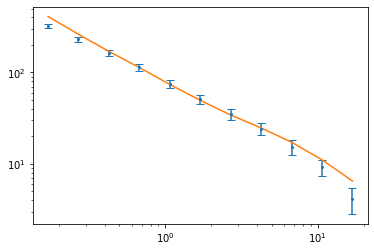

In [43]:
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
plt.plot(bin_cen, wp, label='total')
plt.xscale('log')
plt.yscale('log')

In [47]:
#log liklihood
def lnlike(theta):
    logMmin, sigma_logM, alpha, logM0, logM1 = theta
    cens_occ_model.param_dict['logMmin'] = logMmin
    cens_occ_model.param_dict['sigma_logM'] = sigma_logM
    sats_occ_model.param_dict['alpha'] = alpha
    sats_occ_model.param_dict['logM0'] = logM0
    sats_occ_model.param_dict['logM1'] = logM1
        
    ngal, wp = halotab.predict(model_instance)
    wp_diff = wp_ng_vals[1:12]-wp
    ng_diff = wp_ng_vals[0]-ngal
    
    return -0.5*np.dot(wp_diff, np.dot(invcov, wp_diff)) + -0.5*(ng_diff**2)/(ng_err**2)

#log prior
def lnprior(theta):
    logMmin_r = [1.0,4.0]
    sigma_logM_r = [0.01,2.0]
    alpha_r = [0.5,3.0]
    logM0_r = [1.0,4.0]
    logM1_r = [1.0,4.0]
    
    logMmin, sigma_logM, alpha, logM0, logM1 = theta
    if logMmin_r[0]<logMmin<logMmin_r[1] and sigma_logM_r[0]<sigma_logM<sigma_logM_r[1] and alpha_r[0]<alpha<alpha_r[1] and logM0_r[0]<logM0<logM0_r[1] and logM1_r[0]<logM1<logM1_r[1]:
        return 0.0
    return -np.inf

#log prop
def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf

    ll = lnlike(theta)
    return lp + ll

In [ ]:
nwalkers = 10
ndim = 5
nsteps = 5
guess = [2.13, 0.22, 3.08, 1.47, 2.45]
pos = [guess+1e-4*np.random.randn(ndim) for i in range(nwalkers)]
backend = emcee.backends.HDFBackend('test.h5')
backend.reset(nwalkers, ndim)                                                        
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                        backend=backend)                                                             
sampler.run_mcmc(pos, nsteps, progress=True, store=True)


In [46]:
reader = emcee.backends.HDFBackend('test.h5', read_only=True)

In [ ]:
reader.get_chain(discard=0, flat=False, thin=1)

# Conversions

In [24]:
mvir = halocat.halo_table['halo_mvir']
rvir = halocat.halo_table['halo_rvir']
vmax = halocat.halo_table['halo_vmax']
G = sc.gravitational_constant
vvir = (G*mvir/rvir)**0.5


In [25]:
print(vvir[0],mvir[0],vmax[0])
print(np.log10(vvir[0]),np.log10(vmax[0]),np.log10(mvir[0]))

216.77905 1714800000000000.0 1980.97
2.3360174 3.2968779 15.234214


In [26]:
m, b, r, p, se = ss.linregress(np.log10(vmax), np.log10(mvir))
m = m+0.04
m,b

(3.1069839419403174, 5.015822745222037)

In [27]:
vmax_ml = np.log10(vmax)*(m)+(b)

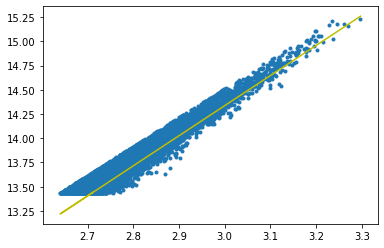

In [98]:
plt.scatter(np.log10(vmax[0:10_000]),np.log10(mvir[0:10_000]),marker='.')
plt.plot(np.log10(vmax[0:10_000]),np.log10(vmax[0:10_000])*(m)+(b),c='y')
#plt.yscale('log')
#plt.xscale('log')

In [68]:
m2, b2, r2, p2, se2 = ss.linregress(vmax_ml, np.log10(vmax))
m2,b2

(0.3260532250619037, -1.6354239489541218)

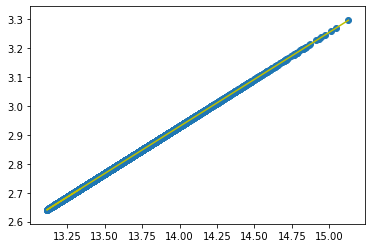

In [46]:
plt.scatter(vmax_ml[0:10000],np.log10(vmax[0:10000]))
plt.plot(vmax_ml[0:10000],vmax_ml[0:10000]*(m2)+(b2),c='y')
#plt.yscale('log')
#plt.xscale('log')

In [69]:
##CONVERT FROM VMAX TO MASS LIKE
#print(10**(np.log10(100)*(m)+(b)),halocat.particle_mass)
#convert Vmax param vals to masslike
        #logVmaxMin, LogVmax0, LogVmax1
vals = [2.29,2.30,2.39]
for v in vals:
    print(np.log(10**(np.log10(v)*(m)+(b))))
alpha_v = 2.37
sigma_v = 0.24
alpha_m = alpha_v/m
sigma_m = m*sigma_v
print(alpha_m)
print(sigma_m)

14.12365587449222
14.137193952303695
14.256453178954066
0.7627976340682117
0.7456761460656761


In [127]:
cens_occ_model = Zheng07Cens(prim_haloprop_key = 'vmax_ml',threshold=threshold)
cens_prof_model = TrivialPhaseSpace()
sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'vmax_ml',threshold=threshold)#, modulate_with_cenocc=True,threshold=threshold)
sats_prof_model = NFWPhaseSpace()
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)
model_instance.populate_mock(halocat)

mean_ncen_vml = cens_occ_model.mean_occupation(prim_haloprop=halocat.halo_table['vmax_ml'])
mean_nsat_vml = sats_occ_model.mean_occupation(prim_haloprop=halocat.halo_table['vmax_ml'])

In [53]:
cens_occ_model = Zheng07Cens(prim_haloprop_key = 'halo_mvir',threshold=threshold)
cens_prof_model = TrivialPhaseSpace()
sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'halo_mvir',threshold=threshold)#, modulate_with_cenocc=True,threshold=threshold)
sats_prof_model = NFWPhaseSpace()
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)
model_instance.populate_mock(halocat)

mean_ncen_v = cens_occ_model.mean_occupation(table=halocat.halo_table)
mean_nsat_v = sats_occ_model.mean_occupation(table=halocat.halo_table)

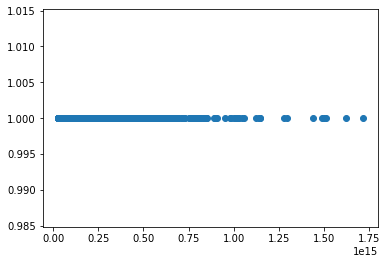

In [59]:
plt.scatter(mvir[0:10000],mean_ncen_v[0:10000])

(0.1, 100)

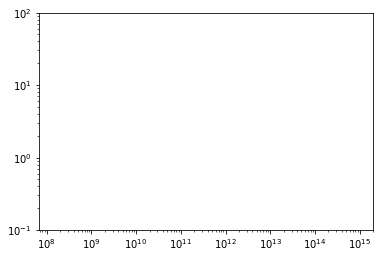

In [129]:
#plt.semilogy(vmax_ml[0:int(0.99e5)],mean_nsat[0:int(0.99e5)],ls='', marker='.')
plt.semilogy(vmax_ml[0:int(0.99e5)],mean_nsat_v[0:int(0.99e5)],ls='', marker='.')
plt.xscale('log')
plt.ylim(0.1,100)

Find Vmax cut off for TabCorr

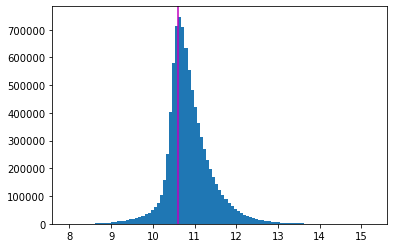

In [52]:
bins = np.linspace(np.min(vmax_ml),np.max(vmax_ml),100)
counts,bins,patches = plt.hist(vmax_ml,bins=bins)
plt.axvline(bins[np.where(counts == np.max(counts))],c='m')


In [76]:
10**(bins[35])#np.where(counts == np.max(counts))])
#np.where(counts == np.max(counts))


41649208277.01889

In [22]:
(bins[np.where(counts == np.max(counts))])

array([8.0064e+10], dtype=float32)

In [11]:
np.max(mvir)
len(mvir)

8693934

[3.52589643e+10]


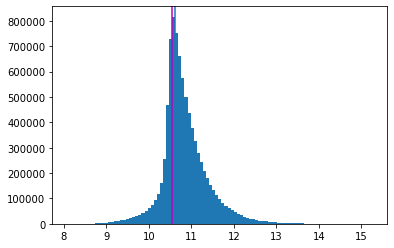

In [73]:
a = 0.6
bins = np.linspace(np.min((1-a)*np.log10(mvir)+a*vmax_ml),np.max((1-a)*np.log10(mvir)+a*vmax_ml),100)
counts,bins,patches = plt.hist((1-a)*np.log10(mvir)+a*vmax_ml,bins=bins)
plt.axvline(bins[np.where(counts == np.max(counts))],c='m')
plt.axvline(10.61197433)
print(10**(bins[np.where(counts == np.max(counts))]))

In [45]:
vmax_ml

15.259169
15.06233
15.14399
15.102642
15.043016
15.172514
14.95793
14.953119
14.934334
14.9754505
14.972649
